<a href="https://colab.research.google.com/github/jasonkao0723/ECE236A-Project2/blob/main/MyDecoder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of Tests:  100 False Positive: 67 False Negative: 162 Hamming: 229
Number of Tests:  200 False Positive: 89 False Negative: 160 Hamming: 249
Number of Tests:  300 False Positive: 67 False Negative: 173 Hamming: 240
Number of Tests:  400 False Positive: 71 False Negative: 153 Hamming: 224
Number of Tests:  500 False Positive: 53 False Negative: 104 Hamming: 157
Number of Tests:  600 False Positive: 51 False Negative: 102 Hamming: 153
Number of Tests:  700 False Positive: 15 False Negative: 43 Hamming: 58
Number of Tests:  800 False Positive: 29 False Negative: 69 Hamming: 98
Number of Tests:  900 False Positive: 19 False Negative: 40 Hamming: 59


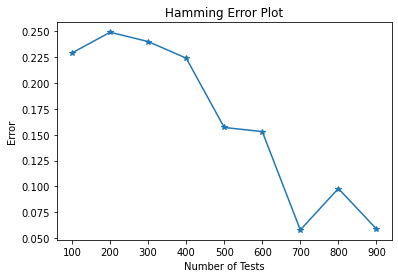

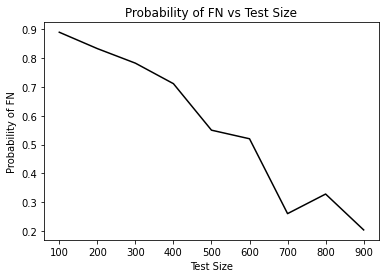

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec  8 19:52:18 2020
@author: hjl
"""

import numpy as np
import cvxpy as cp
import math
from random import shuffle
    

def generator(n, prob_inf, T):
    
    
    ppl = np.random.binomial(size=n, n=1, p= prob_inf)    # ppl is the population
    
    
    col_weight = math.ceil(math.log(2)*T/(n*prob_inf))
    X = np.zeros((T,n))
    X[0:col_weight,:] = 1
    idx = np.random.rand(*X.shape).argsort(0)
    X = X[idx, np.arange(X.shape[1])]
    y_temp = X@ppl #result vector
    y = np.ones_like(y_temp)*(y_temp>=1) #test results
    
    return X,ppl, y #return population and test results

def generator_nonoverlapping(n, q, p, m, T):
    
    ppl = np.zeros(n)    # ppl is the population
    A = np.zeros((m,n)) #family structure matrix
    A[0:1,:] = 1
    idx = np.random.rand(*A.shape).argsort(0)
    A = A[idx, np.arange(A.shape[1])]
    
    inf_families = np.random.binomial(size=m, n=1, p= q)
    
    for i in range(m):
        if inf_families[i] == 1:     #check if family is infected
            indices = A[i,:] == 1    #find the family members
            binom = np.random.binomial(size=np.sum(indices),n=1, p=p)
            ppl[indices] = (ppl[indices] + binom)>0
    
    
    col_weight = math.ceil(math.log(2)*T/(n*q*p)) 
    X = np.zeros((T,n))
    X[0:col_weight,:] = 1
    idx = np.random.rand(*X.shape).argsort(0)
    X = X[idx, np.arange(X.shape[1])]
    y_temp = X@ppl
    y = np.ones_like(y_temp)*(y_temp>=1) #test results
    
    return X, ppl, y, A   #return family structured population, family assignment vector, test results
    
def add_noise_zchannel(y, p_noisy):
    
    y_noisy = np.zeros_like(y)
    indices = y==1
    noise_mask = np.random.binomial(size=np.sum(indices),n=1, p=1-p_noisy)
    y_noisy[indices] = y[indices]*noise_mask
    
    return y_noisy
    
def add_noise_bsc(y, p_noisy):
    
    y_noisy = np.zeros_like(y)
    noise_mask = np.random.binomial(size=y.shape[0],n=1, p=p_noisy)
    y_noisy = (y+noise_mask)%2
    
    return y_noisy
    

def lp(X, y):
    # params
    t, n = X.shape
    
    # cp
    z = cp.Variable(n, boolean=True)
    objective = cp.Minimize(cp.sum(z))
    constraints = [z >= 0, z <= 1]
    for t, y_t in enumerate(y):
        if y_t == 1:
            constraints.append(cp.sum(X[t,:]@z) >= 1)
        else:
            constraints.append(cp.sum(X[t,:]@z) == 0)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return z.value

def lp_nonoverlapping(X,y,A):

    # params
    t, n = X.shape
    
    # cp
    z = cp.Variable(n, boolean=True)
    objective = cp.Minimize(cp.sum(A@z))
    constraints = [z >= 0, z <= 1]
    for t, y_t in enumerate(y):
        if y_t == 1:
            constraints.append(cp.sum(X[t,:]@z) >= 1)
        else:
            constraints.append(cp.sum(X[t,:]@z) == 0)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return z.value
    
def lp_noisy_z(X, y):
    # params
    t, n = X.shape
    zeta = 0.5
    # cp
    z = cp.Variable(n, boolean=True)
    xi = cp.Variable(t)
    objective = cp.Minimize(cp.sum(z) + zeta*cp.sum(xi))
    constraints = [z >= 0, z <= 1, xi >= 0, xi <= 1]
    for t, y_t in enumerate(y):
        if y_t == 1:
            constraints.append(cp.sum(X[t,:]@z) + xi[t] >= 1)
        else:
            constraints.append(cp.sum(X[t,:]@z) - xi[t] >= 0)
    
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return z.value

def lp_noisy_bsc(X, y):
     # params
    t, n = X.shape
    zeta = 0.5
    # cp
    z = cp.Variable(n, boolean=True)
    xi = cp.Variable(t)
    objective = cp.Minimize(cp.sum(z) + zeta*cp.sum(xi))
    constraints = [z >= 0, z <= 1, xi >= 0, xi <= 1]
    for t, y_t in enumerate(y):
        if y_t == 1:
            constraints.append(cp.sum(X[t,:]@z) + xi[t] >= 1)
        else:
            constraints.append(cp.sum(X[t,:]@z) - xi[t] == 0)
    
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return z.value

def lp_noisy_z_nonoverlapping(X, y, A):
    zeta = 0.5
    
    z = cp.Variable(X.shape[1], boolean=True)
    
    X_1 = X[y>0]
    sigma_1 = cp.Variable(X_1.shape[0])

    X_0 = X[y<1]
    sigma_0 = cp.Variable(X_0.shape[0])
    
    constraints = [((X_1 @ z) + sigma_1) >= 1, ((X_0 @ z) - sigma_0) >= 0, z >= 0, z <= 1, sigma_0 == 0, sigma_1 >= 0, sigma_1 <= 1]
    ppl_pred = cp.Problem(cp.Minimize(cp.sum(A @ z) + cp.multiply(zeta, cp.sum(sigma_0) + cp.sum(sigma_1))), constraints)
    # ppl_pred.solve(solver='ECOS_BB')
    ppl_pred.solve()
    
    print(ppl_pred.status)
    
    print(z.value)

    return z.value
    
def lp_noisy_bsc_nonoverlapping(X,y,A):
    zeta = 0.5
    
    z = cp.Variable(X.shape[1], boolean=True)
    
    X_1 = X[y>0]
    sigma_1 = cp.Variable(X_1.shape[0])

    X_0 = X[y<1]
    sigma_0 = cp.Variable(X_0.shape[0])
    
    constraints = [((X_1 @ z) + sigma_1) >= 1, ((X_0 @ z) - sigma_0) >= 0, z >= 0, sigma_0 >= 0, sigma_0 <= 1, sigma_1 >= 0, sigma_1 <= 1]
    ppl_pred = cp.Problem(cp.Minimize(cp.sum(A @ z) + cp.multiply(zeta, cp.sum(sigma_0) + cp.sum(sigma_1))), constraints)
    ppl_pred.solve()

    return z.value


def get_stats(ppl, ppl_pred):
    FP = 0
    FN = 0
    for i, p in enumerate(ppl):
        if ppl_pred[i] != 0 and ppl_pred[i] != 1:
            raise Exception("ppl_pred has invalid element")
        if p == 0 and ppl_pred[i] == 1:
            FP += 1
        elif p == 1 and ppl_pred[i] == 0:
            FN += 1
    Hamming = FP + FN
    return FP, FN, Hamming

def get_prob(ppl, ppl_pred, Type='FN'):
  T = len(ppl)
  count_and = 0
  prior = 0

  if Type == 'FN':
    for t in range(T):
      if ppl[t] == 1 and ppl_pred[t] == 0:
        count_and += 1
    for t in range(T):
      if ppl[t] == 1:
        prior += 1
  elif Type == 'FP':
    for t in range(T):
      if ppl[t] == 0 and ppl_pred[t] == 1:
        count_and += 1
    for t in range(T):
      if ppl[t] == 0:
        prior += 1

  count_and /= T
  prior /= T

  return count_and/prior


def show_non_noisy_results(N, q, p, m):
    test_setSize = np.arange(100, 800, 100)
    predictAcc = np.zeros(test_setSize.shape[0])
    counter = 0

    
    for i_test in test_setSize:
        [X, ppl, y] = generator(N, q, i_test)
        pred_s = lp(X, y)
        predictAcc[counter] = 1-sum(abs((ppl-pred_s.T).T))/1000
        counter += 1

    print(get_stats(ppl, pred_s))
    
    predictAcc_nonoverlapping = np.zeros(test_setSize.shape[0])
    counter = 0
    
    for i_test in test_setSize:
        [X, ppl, y, A] = generator_nonoverlapping(N, q, p, m, i_test)
        pred_s = lp_nonoverlapping(X,y,A)
        predictAcc_nonoverlapping[counter] = 1-sum(abs((ppl-pred_s.T).T))/1000
        counter += 1
        
    print(get_stats(ppl, pred_s))
        
    plt.figure()
    plt.plot(test_setSize,predictAcc,'o-',test_setSize,predictAcc_nonoverlapping,'o-')
    plt.title("Classification Accuracy")
    plt.xlabel("Number of Tests")
    plt.ylabel("Average Accuracy")
    plt.grid(True)
    
def show_noisy_z_results(N, q, p, m, p_noisy):
    test_setSize = np.arange(100, 800, 100)
    predictAcc = np.zeros(test_setSize.shape[0])
    counter = 0

    
    for i_test in test_setSize:
        [X, ppl, y] = generator(N, q, i_test)
        y = add_noise_zchannel(y, p_noisy)
        pred_s = lp_noisy_z(X, y)
        predictAcc[counter] = 1-sum(abs((ppl-pred_s.T).T))/1000
        counter += 1

    predictAcc_nonoverlapping = np.zeros(test_setSize.shape[0])
    counter = 0
    
    for i_test in test_setSize:
        [X, ppl, y, A] = generator_nonoverlapping(N, q, p, m, i_test)
        y = add_noise_zchannel(y, p_noisy)
        pred_s = lp_noisy_z_nonoverlapping(X, y, A)
        predictAcc_nonoverlapping[counter] = 1-sum(abs((ppl-pred_s.T).T))/1000
        counter += 1
        
    plt.figure()
    plt.plot(test_setSize,predictAcc,'o-',test_setSize,predictAcc_nonoverlapping,'o-')
    plt.title("Classification Accuracy")
    plt.xlabel("Number of Tests")
    plt.ylabel("Average Accuracy")
    plt.grid(True)

def run_tests(pop_size, prob_inf, test_size, prob_inf_fam=0, num_fam=0, p_noisy=0, noise=None, comm=False):
  ppl_pred = []
  ppl_list = []

  for t in test_size:
    if comm:
      X, ppl, y, A = generator_nonoverlapping(pop_size, prob_inf_fam, prob_inf, num_fam, t)
      if noise == None:
        temp = lp_nonoverlapping(X, y, A)
      elif noise == 'z':
        y = add_noise_zchannel(y, p_noisy)
        temp = lp_noisy_z_nonoverlapping(X, y, A)
      elif noise == 'bsc':
        y = add_noise_bsc(y, p_noisy)
        temp = lp_noisy_bsc_nonoverlapping(X, y, A)
    else:
      X, ppl, y = generator(pop_size, prob_inf, t)
      if noise == None:
        temp = lp(X, y)
      elif noise == 'z':
        y = add_noise_zchannel(y, p_noisy)
        temp = lp_noisy_z(X, y)
      elif noise == 'bsc':
        y = add_noise_bsc(y, p_noisy)
        temp = lp_noisy_z(X, y)

    ppl_list.append(ppl)     
    ppl_pred.append(temp)

  return ppl_pred, ppl_list

def vis_error(test_size, ppl, ppl_pred):
  FN = []
  FP = []
  Hamming = []

  for i,t in enumerate(test_size):
    P, N, H = get_stats(ppl[i], ppl_pred[i])
    FN.append(N)
    FP.append(P)
    print("Number of Tests: ",t,"False Positive:",P,"False Negative:",N,"Hamming:",H)
    Hamming.append(H/1000)

  plt.figure()
  # plt.plot(test_size, FN, '-o', test_size, FP, '-+')
  plt.plot(test_size, Hamming, '-*')
  plt.title('Hamming Error Plot')
  plt.xlabel('Number of Tests')
  plt.ylabel('Error')
  plt.show()

def vis_prob(test_size, ppl, ppl_pred):
  prob = []
  for i in range(len(test_size)):
      prob.append(get_prob(ppl[i], ppl_pred[i]))
    
  plt.figure()
  plt.plot(test_size, prob, '-0')
  plt.title('Probability of FN vs Test Size')
  plt.xlabel('Test Size')
  plt.ylabel('Probability of FN')
  plt.show()  

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    
    #Change these values according to your needs, you can also define new variables.
    n = 1000                        # size of population
    m = 50                          #number of families
    p = 0.2                         #probability of infection
    q = 0.2                         #probability of a family to be chosen as infected
    T = 200                         #number of tests 
    p_noisy = 0.1                   #test noise
    

    test_size = np.arange(100,1000,100)
    
    ppl_pred, ppl = run_tests(pop_size=n, prob_inf=p, test_size=test_size)
    vis_error(test_size, ppl, ppl_pred)
    vis_prob(test_size, ppl, ppl_pred)
    
    # ppl_pred, ppl = run_tests(pop_size=n, prob_inf=p, prob_inf_fam=q, num_fam=m, test_size=test_size)
    # vis_error(test_size, ppl, ppl_pred)


In [14]:
x = np.array([1,2,3,4])
z = np.array([1,1,1,1])
y = cp.sum(x@z, axis=0, keepdims=False)
print(y)

Sum(10.0, 0, False)
